Demo 4 – Center Initialization with image Moment
200345N

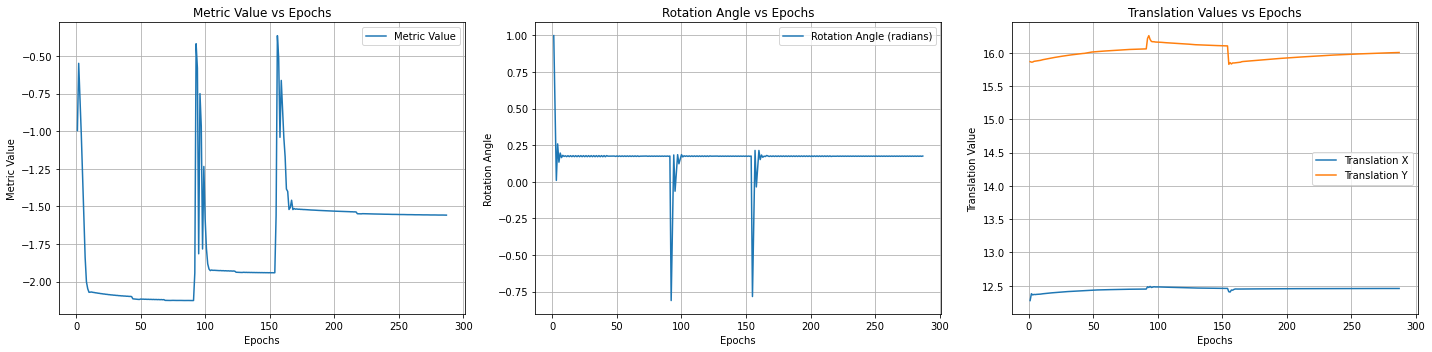

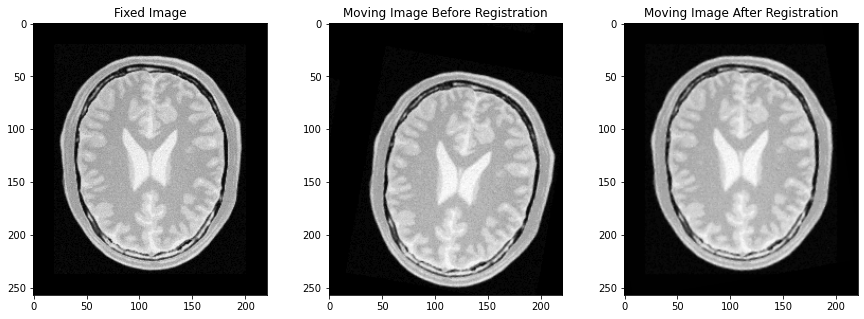

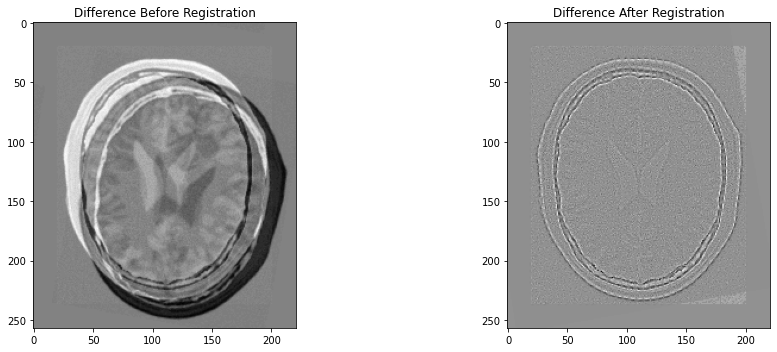

Result: 
Rotation Angle = 0.17547367271518602 radians
Translation X = 12.459223361715196
Translation Y = 16.00348381547324


<itk.itkImageRegistrationMethodv4Python.itkImageRegistrationMethodv4REGv4F2F2; proxy of <Swig Object of type 'itkImageRegistrationMethodv4REGv4F2F2 *' at 0x000001D99B70F360> >

In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np

def perform_centered_moments_registration(fixed_image_path, moving_image_path):
    PixelType = itk.ctype("float")

    # Read images
    fixed_image = itk.imread(fixed_image_path, PixelType)
    moving_image = itk.imread(moving_image_path, PixelType)

    Dimension = fixed_image.GetImageDimension()
    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    # Euler2DTransform for rigid registration
    TransformType = itk.Euler2DTransform[itk.D]
    initial_transform = TransformType.New()

    metric_values = []
    angle_values = []
    translation_x_values = []
    translation_y_values = []

    # Callback to track metrics
    def observer():
        current_parameters = optimizer.GetCurrentPosition()
        angle = current_parameters.GetElement(0)
        translation_x = current_parameters.GetElement(1)
        translation_y = current_parameters.GetElement(2)
        metric_value = optimizer.GetValue()

        metric_values.append(metric_value)
        angle_values.append(angle)
        translation_x_values.append(translation_x)
        translation_y_values.append(translation_y)

    # Optimizer setup
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=1.0,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
    )
    optimizer.AddObserver(itk.IterationEvent(), observer)

    # Use Mattes Mutual Information as the similarity metric
    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    metric.SetNumberOfHistogramBins(50)

    # Registration method setup
    registration = itk.ImageRegistrationMethodv4.New(
        FixedImage=fixed_image,
        MovingImage=moving_image,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initial_transform,
    )

    # Compute center of mass of fixed and moving images using ImageMomentsCalculator
    moments_calculator_fixed = itk.ImageMomentsCalculator[FixedImageType].New()
    moments_calculator_fixed.SetImage(fixed_image)
    moments_calculator_fixed.Compute()
    center_of_mass_fixed = moments_calculator_fixed.GetCenterOfGravity()

    moments_calculator_moving = itk.ImageMomentsCalculator[MovingImageType].New()
    moments_calculator_moving.SetImage(moving_image)
    moments_calculator_moving.Compute()
    center_of_mass_moving = moments_calculator_moving.GetCenterOfGravity()

    # Initialize transform with center of mass of the fixed image
    initial_transform.SetCenter(center_of_mass_fixed)

    # Set initial translation as the difference between the centers of mass
    initial_transform.SetTranslation([center_of_mass_moving[i] - center_of_mass_fixed[i] for i in range(Dimension)])
    initial_transform.SetAngle(0.0)  # Initialize rotation angle to 0

    # Set initial transform in the registration method
    registration.SetInitialTransform(initial_transform)
    
    # Set scales for rotation and translation
    optimizer_scales = [1.0, 1.0 / 10.0, 1.0 / 10.0]  # Rotation and translation scales
    optimizer.SetScales(itk.OptimizerParameters[itk.D](optimizer_scales))

    # Perform registration
    registration.Update()

    # Resample moving image to the fixed image's grid
    resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=registration.GetTransform(), UseReferenceImage=True)
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(itk.LinearInterpolateImageFunction.New(moving_image))
    resampler.Update()
    resampled_moving_image = resampler.GetOutput()

    # Compute difference images before and after registration
    subtract_filter_before = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=moving_image)
    subtract_filter_before.Update()
    difference_before_registration = subtract_filter_before.GetOutput()

    subtract_filter_after = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=resampled_moving_image)
    subtract_filter_after.Update()
    difference_after_registration = subtract_filter_after.GetOutput()

    # Convert the ITK images to NumPy arrays for visualization
    difference_before_registration_array = itk.GetArrayViewFromImage(difference_before_registration)
    difference_after_registration_array = itk.GetArrayViewFromImage(difference_after_registration)
    
    # Plotting metrics and transformation parameters over iterations
    epochs = list(range(1, len(metric_values) + 1))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, metric_values, label="Metric Value")
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Metric Value vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, angle_values, label="Rotation Angle (radians)")
    plt.xlabel('Epochs')
    plt.ylabel('Rotation Angle')
    plt.title('Rotation Angle vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, translation_x_values, label="Translation X")
    plt.plot(epochs, translation_y_values, label="Translation Y")
    plt.xlabel('Epochs')
    plt.ylabel('Translation Value')
    plt.title('Translation Values vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the fixed, moving, and difference images
    plt.figure(figsize=(15, 5))

    # Fixed and moving image before registration
    plt.subplot(1, 3, 1)
    plt.imshow(itk.GetArrayViewFromImage(fixed_image), cmap="gray")
    plt.title("Fixed Image")

    plt.subplot(1, 3, 2)
    plt.imshow(itk.GetArrayViewFromImage(moving_image), cmap="gray")
    plt.title("Moving Image Before Registration")

    # Resampled moving image after registration
    plt.subplot(1, 3, 3)
    plt.imshow(itk.GetArrayViewFromImage(resampled_moving_image), cmap="gray")
    plt.title("Moving Image After Registration")

    plt.figure(figsize=(15, 5))

    # Differences before and after registration
    plt.subplot(1, 2, 1)
    plt.imshow(difference_before_registration_array, cmap="gray")
    plt.title("Difference Before Registration")

    plt.subplot(1, 2, 2)
    plt.imshow(difference_after_registration_array, cmap="gray")
    plt.title("Difference After Registration")

    plt.tight_layout()
    plt.show()

    # Print final transformation parameters
    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
    rotation_angle = final_parameters.GetElement(0)
    translation_along_x = final_parameters.GetElement(1)
    translation_along_y = final_parameters.GetElement(2)

    print(f"Result: \nRotation Angle = {rotation_angle} radians\n"
          f"Translation X = {translation_along_x}\nTranslation Y = {translation_along_y}")

    return registration


# Paths to images
fixed_image_path = "BrainProtonDensitySliceBorder20.png"
moving_image_path = "BrainProtonDensitySliceR10X13Y17.png"

# Perform registration
perform_centered_moments_registration(fixed_image_path, moving_image_path)
